# ANOMALY DETECTION

In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
from scipy import signal

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import cv2
import imutils


In [ ]:
import imageio

def plot_for_offset(im, reconstructed_im, gt_frames, anomalies):
    # Data for plotting
    
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4,figsize=(10,10))
    
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('ground truth ')
    ax3.set_title('anomalies')
    #im = im*255.0
    ax0.imshow(im)
    ax1.imshow(reconstructed_im)
    ax2.imshow(gt_frames)
    ax3.imshow(anomalies)

    
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [ ]:
DATASET_PATH1 ="/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
DATASET_PATH2 ="/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train"

TEST_PATH1 ="/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test" 
TEST_PATH2 ="/content/drive/MyDrive/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test" 

MODEL_PATH = '/content/drive/MyDrive/model/model_lstm_1datasets_diff_arch_256_nomax3.hdf5'

In [ ]:
BATCH_SIZE=2
EPOCHS=3
IMAGE_SIZE = (256,256)
LENGTH_SEQUENCE = 10

In [ ]:
def make_sequences(frames):
    sz = int(frames.shape[0]/LENGTH_SEQUENCE) 
    sequences = np.zeros((sz,LENGTH_SEQUENCE , IMAGE_SIZE[0],IMAGE_SIZE[1], 3)) 
    counter = 0
    for i in range(0, sz):
        clip = np.zeros((LENGTH_SEQUENCE, IMAGE_SIZE[0],IMAGE_SIZE[1], 3))
        for j in range(0, LENGTH_SEQUENCE): 
            clip[j] = frames[counter, :, :, :]
            counter+=1
        sequences[i] = clip
    return(sequences)

In [ ]:
def make_sequence_train(list_frames, length_sequence ):
    row = 0
    len_train_files = list_frames.shape[0]
    len_frames = list_frames.shape[1]
    number_seq = int(len_frames/length_sequence)*len_train_files
    seq = np.zeros((number_seq, length_sequence,IMAGE_SIZE[0],IMAGE_SIZE[1],1))
    for i in range(len_train_files):
        for j in range(0,len_frames,length_sequence):
            for k in range(length_sequence):
                seq[row,k,:,:,0] = list_frames[i,k+j,:,:,0]
            row+=1
    return(seq)

In [ ]:
def get_training_set(DATASET_PATH): 
    files = sorted(glob.glob(DATASET_PATH1+'/*'))
    train_set = np.zeros((len(files),200,IMAGE_SIZE[0],IMAGE_SIZE[1],1))
    for idx, filename in enumerate(files):
        train_files = sorted(glob.glob(filename+'/*'))
        for idx_frame,file_frame in enumerate(train_files):
            im = Image.open(file_frame)
            im = im.resize((IMAGE_SIZE[0],IMAGE_SIZE[1])) 
            train_set[idx,idx_frame,:,:,0] = np.array(im, dtype=np.float32)/255.0
            
    seq = make_sequence_train(train_set,LENGTH_SEQUENCE) 
    return(seq)

In [ ]:
def get_single_test(number):
    files = sorted(glob.glob(TEST_PATH1+'/Test'+str(number).zfill(3)+'/*'))

    test_frames = np.zeros((len(files),IMAGE_SIZE[0],IMAGE_SIZE[1],1))

    for idx,filename in enumerate(files):
        im = cv2.imread(filename)
        im = cv2.resize(im,(IMAGE_SIZE[0],IMAGE_SIZE[1]) )
        
        test_frames[idx,:,:,0] = np.array(im[:,:,0], dtype=np.float32)/255.0
    return(test_frames)

In [ ]:
def get_single_test_MD(number):
    files = sorted(glob.glob(TEST_PATH1+'/Test'+str(number).zfill(3)+'/*'))

    test_frames = np.zeros((len(files),IMAGE_SIZE[0],IMAGE_SIZE[1],3))

    for idx,filename in enumerate(files):
        im = cv2.imread(filename)
        im = cv2.resize(im,(256,256) )
        
        test_frames[idx,:,:,:] = np.array(im, dtype=np.uint8)/255.0
    return(test_frames)

In [ ]:
def get_ground_truth(number):
    
    files = sorted(glob.glob(TEST_PATH1+'/Test'+str(number).zfill(3)+'_gt/*'))

    test_gt_frames = np.zeros((len(files),IMAGE_SIZE[0],IMAGE_SIZE[1],1))

    for idx,filename in enumerate(files):
        im = Image.open(filename)
        im = im.resize((IMAGE_SIZE[0],IMAGE_SIZE[1]))
        test_gt_frames[idx,:,:,0] = np.array(im, dtype=np.float32)/255.0
    return(test_gt_frames)

In [ ]:
def get_ground_truth_MD(number):
    
    files = sorted(glob.glob(TEST_PATH1+'/Test'+str(number).zfill(3)+'_gt/*'))
    test_gt_frames = []
    for idx,filename in enumerate(files):
        im = cv2.imread(filename)
        im = cv2.resize(im,(500,500))
        test_gt_frames.append(im)
    return(test_gt_frames)

In [ ]:
def get_model(reload_model=True):
    
    if not reload_model:
        return load_model(MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(320, (10, 10), strides=2, padding="same"), batch_input_shape=(None, LENGTH_SEQUENCE, IMAGE_SIZE[0],IMAGE_SIZE[1], 1))) #40 sequence
    seq.add(LayerNormalization())
    
    seq.add(TimeDistributed(Conv2D(128, (5,5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    
    seq.add(TimeDistributed(Conv2D(64, (5,5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    
    
    
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True)) 
    seq.add(LayerNormalization())
    
   
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    
    seq.add(TimeDistributed(Conv2DTranspose(128, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    
    seq.add(TimeDistributed(Conv2DTranspose(320, (10, 10), strides=2, padding="same")))   
    seq.add(LayerNormalization())
    
    seq.add(TimeDistributed(Conv2D(1, (10,10), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,
            batch_size=BATCH_SIZE, epochs=EPOCHS, shuffle=False)
    seq.save(MODEL_PATH)
    #seq.show()
    return seq


In [ ]:
def predict_test():
    model = get_model(False)
    print("got model")
    print(test.shape)
           
    sz = int(test.shape[0]/LENGTH_SEQUENCE) 
    sequences = np.zeros((sz,LENGTH_SEQUENCE , IMAGE_SIZE[0],IMAGE_SIZE[1], 1)) 
    counter = 0
    for i in range(0, sz):
        clip = np.zeros((LENGTH_SEQUENCE, IMAGE_SIZE[0],IMAGE_SIZE[1], 1))
        for j in range(0, LENGTH_SEQUENCE): 
            clip[j] = test[counter, :, :, :]
            counter+=1
        sequences[i] = clip

    print("got data")
    #reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    
    plt.plot(sa)
    plt.ylabel('anomaly score Sa(t)')
    plt.xlabel('frame t')
    plt.show()
    return(reconstructed_sequences,sa)

In [ ]:
def predict_gt_motionDetect(reconstructed_sequences, sa,number):
    threshold_anomaly =np.max(sa)/2
    #print(threshold_anomaly)
    test_reshaped = sequences
    frames = []
    threshs=[]
    framedeltas = []
    anomalies = []
    original_frame = []
    firstFrame = None
    #cols_list=[0,1]
    #pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test024/sa.csv', usecols=cols_list)
    for i in range(reconstructed_sequences.shape[0]):
        #print(sa.iloc[i])
        #i['var1'].iloc[0]

        # print(type(sa))
        # print(type(sa(0)))
        # print(type(threshold_anomaly))
        if (sa[i]<threshold_anomaly):

            #print("hello")
            text = "Normal"
            for j in range(LENGTH_SEQUENCE):  
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                thresh = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frameDelta = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                cv2.imwrite('image.png', reconstructed_sequences[i,j,:,:,:])
                image = cv2.imread('image.png') 
                frame_test = np.array(test_reshaped[i,j,:,:,:],dtype=np.uint8)
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                frames.append(frame)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
            firstFrame = None
        
        else:
            #print("else hello")
            #firstFrame = None
            cnt=0
            for k in range(LENGTH_SEQUENCE):
                
                text = "Normal"
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frame_test = np.array(test_reshaped[i,k,:,:,:],dtype=np.uint8)
                #########################
                cv2.imwrite('image.png', reconstructed_sequences[i,k,:,:,:])
                            #*255)
                image = cv2.imread('image.png')
                ###########################
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray = cv2.GaussianBlur(gray, (21, 21), 0)

                if firstFrame is None:
                    firstFrame = gray
                
                frameDelta = cv2.absdiff(firstFrame, gray)   
                thresh = cv2.threshold(frameDelta, 29, 255, cv2.THRESH_BINARY)[1]
            
                thresh = cv2.dilate(thresh, None, iterations=2)
                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
            
                for c in cnts:
                    if cv2.contourArea(c) < 500:
                        continue
                
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.rectangle(anomaly, (x, y), (x + w, y + h), (255, 255, 255), -1)
                    cv2.rectangle(frame_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    text = "Anomaly detected"
            
            
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                frames.append(frame)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
    
    path = '/content/drive/MyDrive/motion_detection/Ped1/Test'+str(number).zfill(3)+'/'
    os.makedirs(os.path.dirname(path), exist_ok=True)            
    imageio.mimsave(path+'frames.gif', [frames[idx] for idx in range(len(frames))], fps=1)
    imageio.mimsave(path+'frames threshs.gif', [threshs[idx] for idx in range(len(threshs))], fps=1)
    imageio.mimsave(path+'frames deltas.gif', [framedeltas[idx] for idx in range(len(framedeltas))], fps=1)
    imageio.mimsave(path+'gt_predicted.gif', [anomalies[idx] for idx in range(len(anomalies))], fps=1)
    imageio.mimsave(path+'original_frame.gif', [original_frame[idx] for idx in range(len(original_frame))], fps=1)
    return(anomalies)
                

In [ ]:
def evaluate_accuracy_image_cv(number, gt_predicted):
    Threshold_acc = 0.2
    test_gt_frames= get_ground_truth_MD(number)
   
    iou_score = np.zeros((1,len(test_gt_frames)))
    for i in range(len(test_gt_frames)):
        frame = gt_predicted[i]
        gt_frames = test_gt_frames[i]
        intersection = cv2.bitwise_and(frame[:,:,0], gt_frames[:,:,0])
        union = cv2.bitwise_or(frame[:,:,0], gt_frames[:,:,0])
        if union.any() == False:
            iou_score[0,i] = 1
        else:
            iou_score[0,i] = np.sum(intersection)/ np.sum(union)
    accuracy = np.sum(iou_score > Threshold_acc)/ iou_score.shape[1]
    return(iou_score, accuracy)

In [ ]:
def classic_accuracy(number, gt_predicted):
    test_gt_frames= get_ground_truth_MD(number)
    
    true_list_new_n=np.array(test_gt_frames)
    pred_list_new_n=np.array(gt_predicted)
    true_list_new_n=true_list_new_n.flatten()
    pred_list_new_n=pred_list_new_n.flatten()
    print("Confusion Matrix: ", 
      confusion_matrix(true_list_new_n, pred_list_new_n)) 

    print ("Accuracy : ", 
       accuracy_score(true_list_new_n,pred_list_new_n)*100) 

    #print("Report : ", 
      #classification_report(true_list_new_n, pred_list_new_n))
    

In [ ]:
def load_predictions(reconstructed_sequences):
    reconstructed_sequences = np.zeros((200,IMAGE_SIZE[0],IMAGE_SIZE[1],3))
    for i in range(200):
        reconstructed_sequences[i,:,:,:] = cv2.imread('/content/drive/MyDrive/prediction/ped1/Test'+str(number).zfill(3)+'/'+str(i+1).zfill(3)+'.png')
      
    sa = pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test'+str(number).zfill(3)+'/sa.csv', index_col=0)
    sa=np.array(sa)
    sequences_pred = make_sequences(reconstructed_sequences)
    return(sequences_pred, sa)


In [ ]:
def saliency_image(image):
    saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
    (success, saliencyMap) = saliency.computeSaliency(image)
    saliencyMap = (saliencyMap * 255).astype("uint8")
    return(saliencyMap)
def predict_gt_saliency(reconstructed_sequences, sa):
    reshaped = np.reshape(reconstructed_sequences, ((200,IMAGE_SIZE[0],IMAGE_SIZE[1],1)))
    
    ground_truth_pred = []
    threshold = 180
    #threshold = 4*255
    for i in range(len(reshaped)):
        idx = int(i/10)
        anomalie=np.zeros((IMAGE_SIZE[0],IMAGE_SIZE[1]))
        
        if sa[idx]<np.max(sa)/2:
            pass
        else:
            predi_image = reshaped[i,:,:,0]*255
            test_image = test[i,:,:,0]*255
            
            diff = np.abs(predi_image-test_image)
            tmp = diff[:,:]
            H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')
            saliency = saliency_image(H)
            
            x,y = np.where(saliency> threshold)
            anomalie[x,y]=1
        
        ground_truth_pred.append(anomalie)
    ground_truth_pred = np.array(ground_truth_pred)
    return(ground_truth_pred)  

# TEST






got model
(200, 256, 256, 1)
got data


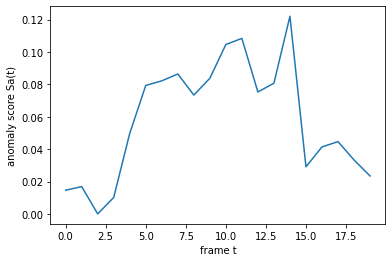

20


In [ ]:
def predict_gt_motionDetect(reconstructed_sequences, sa,number):
    
    threshold_anomaly =np.max(sa)/2
    #print(threshold_anomaly)
    test_reshaped = sequences
    frames = []
    threshs=[]
    framedeltas = []
    anomalies = []
    original_frame = []
    firstFrame = None
    #cols_list=[0,1]
    #pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test024/sa.csv', usecols=cols_list)
    for i in range(reconstructed_sequences.shape[0]):
        #print(sa.iloc[i])
        #i['var1'].iloc[0]

        # print(type(sa))
        # print(type(sa(0)))
        # print(type(threshold_anomaly))
        if (sa[i]<threshold_anomaly):

            #print("hello")
            text = "Normal"
            for j in range(LENGTH_SEQUENCE):  
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                thresh = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frameDelta = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                cv2.imwrite('image.png', reconstructed_sequences[i,j,:,:,:])
                image = cv2.imread('image.png') 
                frame_test = np.array(test_reshaped[i,j,:,:,:],dtype=np.uint8)
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                frames.append(frame)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
            firstFrame = None
        
        else:
            #print("else hello")
            #firstFrame = None
            cnt=0
            for k in range(LENGTH_SEQUENCE):
                
                text = "Normal"
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frame_test = np.array(test_reshaped[i,k,:,:,:],dtype=np.uint8)
                #########################
                cv2.imwrite('image.png', reconstructed_sequences[i,k,:,:,:])
                            #*255)
                image = cv2.imread('image.png')
                ###########################
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray = cv2.GaussianBlur(gray, (21, 21), 0)

                if firstFrame is None:
                    firstFrame = gray
                
                frameDelta = cv2.absdiff(firstFrame, gray)   
                thresh = cv2.threshold(frameDelta, 29, 255, cv2.THRESH_BINARY)[1]
            
                thresh = cv2.dilate(thresh, None, iterations=2)
                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
            
                for c in cnts:
                    if cv2.contourArea(c) < 500:
                        continue
                
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.rectangle(anomaly, (x, y), (x + w, y + h), (255, 255, 255), -1)
                    cv2.rectangle(frame_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    text = "Anomaly detected"
            
            
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                frames.append(frame)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
    
    path = '/content/drive/MyDrive/motion_detection/Ped1/Test'+str(number).zfill(3)+'/'
    os.makedirs(os.path.dirname(path), exist_ok=True)            
    imageio.mimsave(path+'frames.gif', [frames[idx] for idx in range(100,len(frames))], fps=3)
    imageio.mimsave(path+'frames threshs.gif', [threshs[idx] for idx in range(100,len(threshs))], fps=3)
    imageio.mimsave(path+'frames deltas.gif', [framedeltas[idx] for idx in range(100,len(framedeltas))], fps=3)
    imageio.mimsave(path+'gt_predicted.gif', [anomalies[idx] for idx in range(100,len(anomalies))], fps=3)
    imageio.mimsave(path+'original_frame.gif', [original_frame[idx] for idx in range(100,len(original_frame))], fps=3)
    return(anomalies)

number = 1

test = get_single_test(number)
predicted_sequences, sa= predict_test()   
reshaped = np.reshape(predicted_sequences, ((predicted_sequences.shape[0]*LENGTH_SEQUENCE,IMAGE_SIZE[0],IMAGE_SIZE[1],1)))
for i in range(200):
    path = '/content/drive/MyDrive/testing_path/Peds1/Test'+str(number).zfill(3)+'/'+str(i+1).zfill(3)+'.png'
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, reshaped[i,:,:,0]*255)

sa = pd.DataFrame(sa, columns=['sa'])
path = '/content/drive/MyDrive/prediction/ped1/Test'+str(number).zfill(3)+'/sa.csv'
os.makedirs(os.path.dirname(path), exist_ok=True)
sa.to_csv(path)
sequences_pred = predicted_sequences*255
test = get_single_test_MD(number)
sequences = make_sequences(test*255)
newarr=[]
import pandas as pd
col_list=["sa"]
saa = pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test024/sa.csv',usecols=col_list)
print(saa.shape[0])
for i in range(saa.shape[0]):
  newarr.append(float(saa.iloc[i].to_string().split()[1]))
predictions=predict_gt_motionDetect(sequences_pred,newarr,number)

# TEST on 

In [ ]:
def predict_gt_motionDetect(reconstructed_sequences, sa,number):
    
    threshold_anomaly =np.max(sa)/2
    print(threshold_anomaly)
    test_reshaped = sequences
    frames = []
    threshs=[]
    framedeltas = []
    anomalies = []
    original_frame = []
    firstFrame = None
    #cols_list=[0,1]
    #pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test024/sa.csv', usecols=cols_list)
    for i in range(reconstructed_sequences.shape[0]):
        #print(sa.iloc[i])
        #i['var1'].iloc[0]

        # print(type(sa))
        # print(type(sa(0)))
        # print(type(threshold_anomaly))
        if (sa[i]<threshold_anomaly):

            #print("hello")
            text = "Normal"
            for j in range(LENGTH_SEQUENCE):  
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                thresh = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frameDelta = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                cv2.imwrite('image.png', reconstructed_sequences[i,j,:,:,:])
                image = cv2.imread('image.png') 
                frame_test = np.array(test_reshaped[i,j,:,:,:],dtype=np.uint8)
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                frames.append(frame)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
            firstFrame = None
        
        else:
            #print("else hello")
            #firstFrame = None
            cnt=0
            for k in range(LENGTH_SEQUENCE):
                
                text = "Normal"
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frame_test = np.array(test_reshaped[i,k,:,:,:],dtype=np.uint8)
                #########################
                cv2.imwrite('image.png', reconstructed_sequences[i,k,:,:,:])
                            #*255)
                image = cv2.imread('image.png')
                ###########################
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray = cv2.GaussianBlur(gray, (21, 21), 0)

                if firstFrame is None:
                    firstFrame = gray
                
                frameDelta = cv2.absdiff(firstFrame, gray)   
                thresh = cv2.threshold(frameDelta, 29, 255, cv2.THRESH_BINARY)[1]
            
                thresh = cv2.dilate(thresh, None, iterations=2)
                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
            
                for c in cnts:
                    if cv2.contourArea(c) < 500:
                        continue
                
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.rectangle(anomaly, (x, y), (x + w, y + h), (255, 255, 255), -1)
                    cv2.rectangle(frame_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    text = "Anomaly detected"
            
            
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                frames.append(frame)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
    
    path = '/content/drive/MyDrive/motion_detection/Ped1/Test'+str(number).zfill(3)+'/'
    os.makedirs(os.path.dirname(path), exist_ok=True)            
    imageio.mimsave(path+'frames.gif', [frames[idx] for idx in range(150,len(frames))], fps=1)
    imageio.mimsave(path+'frames threshs.gif', [threshs[idx] for idx in range(150,len(threshs))], fps=1)
    imageio.mimsave(path+'frames deltas.gif', [framedeltas[idx] for idx in range(150,len(framedeltas))], fps=1)
    imageio.mimsave(path+'gt_predicted.gif', [anomalies[idx] for idx in range(150,len(anomalies))], fps=1)
    imageio.mimsave(path+'original_frame.gif', [original_frame[idx] for idx in range(150,len(original_frame))], fps=1)
    return(anomalies)

In [ ]:
number = 24

In [ ]:
test = get_single_test(number)


got model
(200, 256, 256, 1)
got data


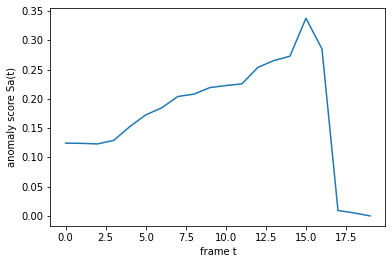

In [ ]:
predicted_sequences, sa= predict_test()

In [ ]:
#### Save the predicted seqeunces 
reshaped = np.reshape(predicted_sequences, ((predicted_sequences.shape[0]*LENGTH_SEQUENCE,IMAGE_SIZE[0],IMAGE_SIZE[1],1)))
for i in range(200):
    path = '/content/drive/MyDrive/testing_path/Peds1/Test'+str(number).zfill(3)+'/'+str(i+1).zfill(3)+'.png'
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, reshaped[i,:,:,0]*255)

sa = pd.DataFrame(sa, columns=['sa'])
path = '/content/drive/MyDrive/prediction/ped1/Test'+str(number).zfill(3)+'/sa.csv'
os.makedirs(os.path.dirname(path), exist_ok=True)
sa.to_csv(path)

In [ ]:
sequences_pred = predicted_sequences*255

In [ ]:
test = get_single_test_MD(number)

In [ ]:
sequences = make_sequences(test*255)

In [ ]:
newarr=[]
import pandas as pd
col_list=["sa"]
saa = pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test024/sa.csv',usecols=col_list)
print(saa.shape[0])
for i in range(saa.shape[0]):
  newarr.append(float(saa.iloc[i].to_string().split()[1]))
print(newarr)
print(type(newarr[0]))




20
[0.124453, 0.124032, 0.123108, 0.129119, 0.152561, 0.172722, 0.184843, 0.20413, 0.208166, 0.219337, 0.222866, 0.225689, 0.253926, 0.265602, 0.273036, 0.337907, 0.285401, 0.009284, 0.005121, 0.0]
<class 'float'>


In [ ]:
predictions=predict_gt_motionDetect(sequences_pred,newarr,number)

0.1689535


# TEST on 

In [ ]:
def predict_gt_motionDetect(reconstructed_sequences, sa,number):
    
    threshold_anomaly =np.max(sa)/2
    print(threshold_anomaly)
    test_reshaped = sequences
    frames = []
    threshs=[]
    framedeltas = []
    anomalies = []
    original_frame = []
    firstFrame = None
    #cols_list=[0,1]
    #pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test024/sa.csv', usecols=cols_list)
    for i in range(reconstructed_sequences.shape[0]):
        #print(sa.iloc[i])
        #i['var1'].iloc[0]

        # print(type(sa))
        # print(type(sa(0)))
        # print(type(threshold_anomaly))
        if (sa[i]<threshold_anomaly):

            #print("hello")
            text = "Normal"
            for j in range(LENGTH_SEQUENCE):  
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                thresh = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frameDelta = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                cv2.imwrite('image.png', reconstructed_sequences[i,j,:,:,:])
                image = cv2.imread('image.png') 
                frame_test = np.array(test_reshaped[i,j,:,:,:],dtype=np.uint8)
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                frames.append(frame)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
            firstFrame = None
        
        else:
            #print("else hello")
            #firstFrame = None
            cnt=0
            for k in range(LENGTH_SEQUENCE):
                
                text = "Normal"
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frame_test = np.array(test_reshaped[i,k,:,:,:],dtype=np.uint8)
                #########################
                cv2.imwrite('image.png', reconstructed_sequences[i,k,:,:,:])
                            #*255)
                image = cv2.imread('image.png')
                ###########################
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray = cv2.GaussianBlur(gray, (21, 21), 0)

                if firstFrame is None:
                    firstFrame = gray
                
                frameDelta = cv2.absdiff(firstFrame, gray)   
                thresh = cv2.threshold(frameDelta, 29, 255, cv2.THRESH_BINARY)[1]
            
                thresh = cv2.dilate(thresh, None, iterations=2)
                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
            
                for c in cnts:
                    if cv2.contourArea(c) < 500:
                        continue
                
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.rectangle(anomaly, (x, y), (x + w, y + h), (255, 255, 255), -1)
                    cv2.rectangle(frame_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    text = "Anomaly detected"
            
            
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                frames.append(frame)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
    
    path = '/content/drive/MyDrive/motion_detection/Ped1/Test'+str(number).zfill(3)+'/'
    os.makedirs(os.path.dirname(path), exist_ok=True)            
    imageio.mimsave(path+'frames.gif', [frames[idx] for idx in range(len(frames))], fps=1)
    imageio.mimsave(path+'frames threshs.gif', [threshs[idx] for idx in range(len(threshs))], fps=1)
    imageio.mimsave(path+'frames deltas.gif', [framedeltas[idx] for idx in range(len(framedeltas))], fps=1)
    imageio.mimsave(path+'gt_predicted.gif', [anomalies[idx] for idx in range(len(anomalies))], fps=1)
    imageio.mimsave(path+'original_frame.gif', [original_frame[idx] for idx in range(53,len(original_frame))], fps=1)
    return(anomalies)
                

In [ ]:
number = 3

In [ ]:
test = get_single_test(number)


got model
(200, 256, 256, 1)
got data


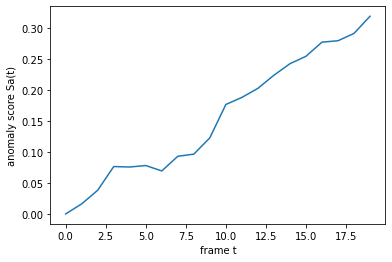

In [ ]:
predicted_sequences, sa= predict_test()

In [ ]:
np.max(sa)/2

0.15936788139623886

In [ ]:
#### Save the predicted seqeunces 
reshaped = np.reshape(predicted_sequences, ((predicted_sequences.shape[0]*LENGTH_SEQUENCE,IMAGE_SIZE[0],IMAGE_SIZE[1],1)))
for i in range(200):
    path = '/content/drive/MyDrive/testing_path/Peds1/Test'+str(number).zfill(3)+'/'+str(i+1).zfill(3)+'.png'
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, reshaped[i,:,:,0]*255)

sa = pd.DataFrame(sa, columns=['sa'])
path = '/content/drive/MyDrive/prediction/ped1/Test'+str(number).zfill(3)+'/sa.csv'
os.makedirs(os.path.dirname(path), exist_ok=True)
sa.to_csv(path)

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

True

In [ ]:
##### load predicted sequences 
#sequences_pred = load_predictions(predicted_sequences)

In [ ]:
sequences_pred = predicted_sequences*255
sequences_pred.shape

(20, 10, 256, 256, 1)

In [ ]:
test = get_single_test_MD(number)

In [ ]:
sequences = make_sequences(test*255)
sequences.shape

(20, 10, 256, 256, 3)

In [ ]:
newarr=[]
import pandas as pd
col_list=["sa"]
saa = pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test024/sa.csv',usecols=col_list)
print(saa.shape[0])
for i in range(saa.shape[0]):
  newarr.append(float(saa.iloc[i].to_string().split()[1]))
print(newarr)
print(type(newarr[0]))




20
[0.124453, 0.124032, 0.123108, 0.129119, 0.152561, 0.172722, 0.184843, 0.20413, 0.208166, 0.219337, 0.222866, 0.225689, 0.253926, 0.265602, 0.273036, 0.337907, 0.285401, 0.009284, 0.005121, 0.0]
<class 'float'>


In [ ]:
predictions=predict_gt_motionDetect(sequences_pred,newarr,number)

0.1689535


# Test


In [ ]:
def predict_gt_motionDetect(reconstructed_sequences, sa,number):
    
    threshold_anomaly =np.max(sa)/2
    #print(threshold_anomaly)
    test_reshaped = sequences
    frames = []
    threshs=[]
    framedeltas = []
    anomalies = []
    original_frame = []
    firstFrame = None
    #cols_list=[0,1]
    #pd.read_csv('/content/drive/MyDrive/prediction/ped1/Test024/sa.csv', usecols=cols_list)
    for i in range(reconstructed_sequences.shape[0]):
        #print(sa.iloc[i])
        #i['var1'].iloc[0]

        # print(type(sa))
        # print(type(sa(0)))
        # print(type(threshold_anomaly))
        if (sa[i]<threshold_anomaly):

            #print("hello")
            text = "Normal"
            for j in range(LENGTH_SEQUENCE):  
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                thresh = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frameDelta = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                cv2.imwrite('image.png', reconstructed_sequences[i,j,:,:,:])
                image = cv2.imread('image.png') 
                frame_test = np.array(test_reshaped[i,j,:,:,:],dtype=np.uint8)
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                frames.append(frame)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
            firstFrame = None
        
        else:
            #print("else hello")
            #firstFrame = None
            cnt=0
            for k in range(LENGTH_SEQUENCE):
                
                text = "Normal"
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frame_test = np.array(test_reshaped[i,k,:,:,:],dtype=np.uint8)
                #########################
                cv2.imwrite('image.png', reconstructed_sequences[i,k,:,:,:])
                            #*255)
                image = cv2.imread('image.png')
                ###########################
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray = cv2.GaussianBlur(gray, (21, 21), 0)

                if firstFrame is None:
                    firstFrame = gray
                
                frameDelta = cv2.absdiff(firstFrame, gray)   
                thresh = cv2.threshold(frameDelta, 29, 255, cv2.THRESH_BINARY)[1]
            
                thresh = cv2.dilate(thresh, None, iterations=2)
                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
            
                for c in cnts:
                    if cv2.contourArea(c) < 500:
                        continue
                
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.rectangle(anomaly, (x, y), (x + w, y + h), (255, 255, 255), -1)
                    cv2.rectangle(frame_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    text = "Anomaly detected"
            
            
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                frames.append(frame)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
    
    path = '/content/drive/MyDrive/motion_detection/Ped1/Test'+str(number).zfill(3)+'/'
    os.makedirs(os.path.dirname(path), exist_ok=True)            
    imageio.mimsave(path+'frames.gif', [frames[idx] for idx in range(len(frames))], fps=1)
    imageio.mimsave(path+'frames threshs.gif', [threshs[idx] for idx in range(len(threshs))], fps=1)
    imageio.mimsave(path+'frames deltas.gif', [framedeltas[idx] for idx in range(len(framedeltas))], fps=1)
    imageio.mimsave(path+'gt_predicted.gif', [anomalies[idx] for idx in range(len(anomalies))], fps=1)
    imageio.mimsave(path+'original_frame.gif', [original_frame[idx] for idx in range(len(original_frame))], fps=1)
    return(anomalies)


In [ ]:
number = 24

In [ ]:
test = get_single_test(number)


got model
(200, 256, 256, 1)
got data


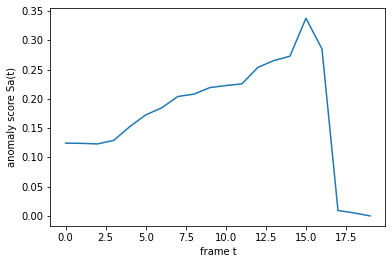

In [ ]:
predicted_sequences, sa= predict_test()

In [ ]:
sequences_pred = predicted_sequences*255
sequences_pred.shape

(20, 10, 256, 256, 1)

In [ ]:
test = get_single_test_MD(number)

In [ ]:
sequences = make_sequences(test*255)
sequences.shape

(20, 10, 256, 256, 3)

In [ ]:
predictions =predict_gt_motionDetect(sequences_pred,sa,number)

# Test on Peds2

In [ ]:
DATASET_PATH1 ="UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train"

TEST_PATH1 ="UCSD_Anomaly_Dataset/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test" 

MODEL_PATH = './model/model_lstm_1datasets_diff_arch_256_nomax_peds2_2.hdf5'

In [ ]:
def get_training_set():
    files1 = sorted(glob.glob(DATASET_PATH2+'/*'))
    
    train_set = []
    for idx, filename in enumerate(files1):
        train_files = sorted(glob.glob(filename+'/*'))
        for idx_frame,file_frame in enumerate(train_files):
            im = Image.open(file_frame)
            im = im.resize((IMAGE_SIZE[0],IMAGE_SIZE[1])) #resize 256, 256 
            train_set.append(np.array(im, dtype=np.float32)/np.float(IMAGE_SIZE[0]))
    train = np.asarray(train_set)
    train = np.reshape(train,((-1,256,256,1)))
    
    seq1 = make_sequences(train) ##num sequence 10
   
    return(seq1)

In [ ]:
number = 2

In [ ]:
test = get_single_test(number)


got model
(180, 256, 256, 1)
got data


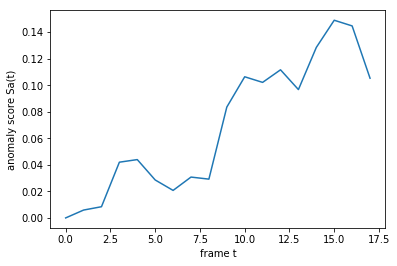

In [ ]:
predicted_sequences, sa= predict_test()

In [ ]:
def predict_gt_motionDetect(reconstructed_sequences, sa,number):
    
    threshold_anomaly =np.max(sa)/2
    test_reshaped = sequences
    frames = []
    threshs=[]
    framedeltas = []
    anomalies = []
    original_frame = []
    firstFrame = None
    for i in range(reconstructed_sequences.shape[0]):
        
        if sa[i]<threshold_anomaly:
            text = "Normal"
            for j in range(LENGTH_SEQUENCE):  
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                thresh = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frameDelta = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                cv2.imwrite('image.png', reconstructed_sequences[i,j,:,:,:])
                image = cv2.imread('image.png') 
                frame_test = np.array(test_reshaped[i,j,:,:,:],dtype=np.uint8)
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                frames.append(frame)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
            firstFrame = None
        
        else:
            #firstFrame = None
            cnt=0
            for k in range(LENGTH_SEQUENCE):
                
                text = "Normal"
                anomaly = np.zeros(shape=[IMAGE_SIZE[0],IMAGE_SIZE[1], 3], dtype=np.uint8)
                frame_test = np.array(test_reshaped[i,k,:,:,:],dtype=np.uint8)
                #########################
                cv2.imwrite('image.png', reconstructed_sequences[i,k,:,:,:])
                            #*255)
                image = cv2.imread('image.png')
                ###########################
                frame_predicted = np.array(image,dtype=np.uint8)      
                frame = cv2.absdiff(frame_test,frame_predicted)
                frame = cv2.GaussianBlur(frame, (5, 5), 0)           
                frame = imutils.resize(frame, width=500)
                anomaly= imutils.resize(anomaly, width=500)
                frame_test= imutils.resize(frame_test, width=500)
                
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                gray = cv2.GaussianBlur(gray, (21, 21), 0)

                if firstFrame is None:
                    firstFrame = gray
                
                frameDelta = cv2.absdiff(firstFrame, gray)   
                thresh = cv2.threshold(frameDelta, 50, 255, cv2.THRESH_BINARY)[1]
            
                thresh = cv2.dilate(thresh, None, iterations=2)
                cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
                cnts = imutils.grab_contours(cnts)
            
                for c in cnts:
                    if cv2.contourArea(c) < 250:
                        continue
                
                    (x, y, w, h) = cv2.boundingRect(c)
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    cv2.rectangle(anomaly, (x, y), (x + w, y + h), (255, 255, 255), -1)
                    cv2.rectangle(frame_test, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    text = "Anomaly detected"
            
            
                cv2.putText(frame, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                cv2.putText(frame_test, "Status: {}".format(text), (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                
                frames.append(frame)
                threshs.append(thresh)
                framedeltas.append(frameDelta)
                anomalies.append(anomaly)
                original_frame.append(frame_test)
    
    path = './motion detection/Peds2/Test'+str(number).zfill(3)+'/'
    os.makedirs(os.path.dirname(path), exist_ok=True)            
    imageio.mimsave(path+'frames.gif', [frames[idx] for idx in range(len(frames))], fps=1)
    imageio.mimsave(path+'frames threshs.gif', [threshs[idx] for idx in range(len(threshs))], fps=1)
    imageio.mimsave(path+'frames deltas.gif', [framedeltas[idx] for idx in range(len(framedeltas))], fps=1)
    imageio.mimsave(path+'gt_predicted.gif', [anomalies[idx] for idx in range(len(anomalies))], fps=1)
    imageio.mimsave(path+'original_frame.gif', [original_frame[idx] for idx in range(len(original_frame))], fps=1)
    return(anomalies)
                

In [ ]:
#### Save the predicted seqeunces 
reshaped = np.reshape(predicted_sequences, ((predicted_sequences.shape[0]*LENGTH_SEQUENCE,IMAGE_SIZE[0],IMAGE_SIZE[1],1)))
for i in range(180):
    path = './predictions/Peds2/Test'+str(number).zfill(3)+'/'+str(i+1).zfill(3)+'.png'
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, reshaped[i,:,:,0]*255)

sa = pd.DataFrame(sa, columns=['sa'])
path = './predictions/Peds2/Test'+str(number).zfill(3)+'/sa.csv'
os.makedirs(os.path.dirname(path), exist_ok=True)
sa.to_csv(path)
sa = np.array(sa)

In [ ]:
sequences_pred = predicted_sequences*255
sequences_pred.shape

(18, 10, 256, 256, 1)

In [ ]:
test = get_single_test_MD(number)

In [ ]:
sequences = make_sequences(test*255)
sequences.shape

(18, 10, 256, 256, 3)

In [ ]:
predictions =predict_gt_motionDetect(sequences_pred,sa,number)

In [ ]:
IoU, accuracy = evaluate_accuracy_image_cv(number,predictions)
print('IoU is %s' % IoU)
print('Accuracy is %s' % accuracy)

IoU is [[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         0.         0.
  0.18438361 0.32445806 0.3807884

In [ ]:
classic_accuracy(number, predictions)

Confusion Matrix:  [[134262045         0         0 ...         0         0     77877]
 [      582         0         0 ...         0         0        84]
 [      792         0         0 ...         0         0        87]
 ...
 [      675         0         0 ...         0         0       141]
 [      507         0         0 ...         0         0       117]
 [   395628         0         0 ...         0         0    144786]]
Accuracy :  99.56061555555556
